# AutoML with Image data - Using AutoGluon 


Here we demonstrate how to train models for classifying images with AutoGluon. AutoGluon can be used [for object detection](https://autogluon.mxnet.io/tutorials/object_detection/beginner.html) in a similar manner.  Our tutorial will not dive into the technical details of [convolutional neural networks](http://d2l.ai/chapter_convolutional-neural-networks/index.html) and modern [computer vision](http://d2l.ai/chapter_computer-vision/index.html); for  background on this, please study ([Zhang, 2020](http://d2l.ai/)) chapters 6, 7, and 13. 


As for tabular data, AutoGluon helps you easily train models for these vision tasks with just a single call to `fit()`.  We begin by specifying `ImageClassification` as our task of interest: 

In [1]:
import autogluon as ag
from autogluon import ImageClassification as task

import os, mxnet
import matplotlib.pyplot as plt

## Format Image Dataset

Our image classification task is based on a subset of the [Shopee-IET dataset](https://www.kaggle.com/c/shopee-iet-machine-learning-competition/data). Each image in this data depicts a clothing item and the corresponding label specifies its clothing category.
Our subset of the data contains the following possible labels: `BabyPants`, `BabyShirt`, `womencasualshoes`, `womenchiffontop`.  This dataset is quite small to ensure the tutorial can be run reasonably fast, so note that reported accuracy numbers may not be particularly reliable.  We can download the data subset and unzip it via the following commands:

In [2]:
filename = ag.download('https://autogluon.s3.amazonaws.com/datasets/shopee-iet.zip')
data_folder = ag.unzip(filename)

train_folder = data_folder+os.sep+'train'+os.sep
test_folder = data_folder+os.sep+'test'+os.sep
print("Training dataset stored in folder:", train_folder)
print("Test dataset stored in folder:", test_folder, "\n")

print("Example files in training dataset:\n\ntrain/")
class_names = os.listdir(train_folder)
num_class = len(class_names)
imgfile_perclass = []
num_img_perclass = []
for label in class_names:
    print("├──", label+os.sep)
    file_names = os.listdir(train_folder+label)
    imgfile_perclass.append(train_folder+label+os.sep+file_names[0])
    num_img_perclass.append(len(file_names))
    for filename in file_names[:2]:
        print("    ├──", filename)
    print("    ├── ...")

    
print("Number of images per class:", {class_names[i]:num_img_perclass[i] for i in range(num_class)})
print("\n Some (image, label) training examples:")
fig, axs = plt.subplots(1, num_class, gridspec_kw={'wspace': 1.0}, figsize=(15,10))
for i in range(num_class):
    img = mxnet.image.imread(filename=imgfile_perclass[i])
    axs[i].imshow(img.asnumpy())
    axs[i].set_title(class_names[i])
plt.show()

Training dataset stored in folder: data/train/
Test dataset stored in folder: data/test/ 

Example files in training dataset:

train/
├── BabyPants/
    ├── BabyPants_939.jpg
    ├── BabyPants_463.jpg
    ├── ...
├── womenchiffontop/
    ├── womenchiffontop_2633.jpg
    ├── womenchiffontop_2454.jpg
    ├── ...
├── womencasualshoes/
    ├── womencasualshoes_1060.jpg
    ├── womencasualshoes_2775.jpg
    ├── ...
├── BabyShirt/
    ├── BabyShirt_376.jpg
    ├── BabyShirt_168.jpg
    ├── ...
Number of images per class: {'BabyPants': 200, 'womenchiffontop': 200, 'womencasualshoes': 200, 'BabyShirt': 200}

 Some (image, label) training examples:


AutoGluon can work with image-datasets stored in either  [RecordIO format](https://mxnet.apache.org/versions/1.6/api/faq/recordio.html) or the image-folder format used for this Shopee-IET dataset, where each subdirectory corresponds to a class-label and the images from this class are stored in separate files within the subdirectory. Let's load the image data into AutoGluon:

In [3]:
train_data = task.Dataset('data/train')
print(train_data)

AutoGluonObject


Unlike for tabular data, AutoGluon avoids loading the full image dataset (which can be quite large) into memory.
We can work with the `Dataset` object like this:

In [4]:
train_loaded = train_data.init() # must initialize before interacting with this object 
print("Ordered class labels:", train_loaded.classes) # predictions will be class-indices corresponding to this list

Ordered class labels: ['BabyPants', 'BabyShirt', 'womencasualshoes', 'womenchiffontop']


## Fit Models with AutoGluon

We now train an image classification model:

In [5]:
num_train_epochs = 3 # How many epochs to train each network. Small value used just for quick demo, you should increase it.
num_hpo_trials = 2 # How many networks to train with different hyperparameters. Small value used just for quick demo, you should increase it.
ngpus_per_trial = 1 # How many GPUs to use per training run. Set =0 if you don't have GPU but beware of slow run-times (otherwise make sure GPU-version of MXNet is installed).
model_folder = 'shopeeietClassifier'

classifier = task.fit(train_data, output_directory=model_folder, verbose=True,
                      epochs=num_train_epochs, num_trials=num_hpo_trials, ngpus_per_trial=ngpus_per_trial)

scheduler_options: Key 'training_history_callback_delta_secs': Imputing default value 60
scheduler_options: Key 'delay_get_config': Imputing default value True

Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 2


scheduler: FIFOScheduler(
DistributedResourceManager{
(Remote: Remote REMOTE_ID: 0, 
	<Remote: 'inproc://172.31.68.247/12139/1' processes=1 threads=4, memory=64.28 GB>, Resource: NodeResourceManager(4 CPUs, 1 GPUs))
})



{'dataset': <autogluon.task.image_classification.dataset.NativeImageFolderDataset object at 0x7f5ac5fb3310>, 'net': 'ResNet50_v1b', 'optimizer': <autogluon.core.optimizer.NAG object at 0x7f5ae0d4e290>, 'loss': SoftmaxCrossEntropyLoss(batch_axis=0, w=None), 'metric': 'accuracy', 'num_gpus': 1, 'split_ratio': 0.8, 'batch_size': 64, 'input_size': 224, 'epochs': 3, 'final_fit_epochs': 3, 'verbose': True, 'num_workers': 4, 'hybridize': True, 'final_fit': False, 'tricks': Dict{'last_gamma': False, 'use_pretrained': True, 'use_se': False, 'mixup': False, 'mixup_alpha': 0.2, 'mixup_off_epoch': 0, 'label_smoothing': False, 'no_wd': False, 'teacher_name': None, 'temperature': 20.0, 'hard_weight': 0.5, 'batch_norm': False, 'use_gn': False}, 'lr_config': Dict{'lr_mode': 'cosine', 'lr_decay': 0.1, 'lr_decay_period': 0, 'lr_decay_epoch': '40,80', 'warmup_lr': 0.0, 'warmup_epochs': 0}, 'task_id': 0}


{'dataset': <autogluon.task.image_classification.dataset.NativeImageFolderDataset object at 0x7f5ac5fb36d0>, 'net': 'ResNet50_v1b', 'optimizer': <autogluon.core.optimizer.NAG object at 0x7f5ae32da390>, 'loss': SoftmaxCrossEntropyLoss(batch_axis=0, w=None), 'metric': 'accuracy', 'num_gpus': 1, 'split_ratio': 0.8, 'batch_size': 64, 'input_size': 224, 'epochs': 3, 'final_fit_epochs': 3, 'verbose': True, 'num_workers': 4, 'hybridize': True, 'final_fit': False, 'tricks': Dict{'last_gamma': False, 'use_pretrained': True, 'use_se': False, 'mixup': False, 'mixup_alpha': 0.2, 'mixup_off_epoch': 0, 'label_smoothing': False, 'no_wd': False, 'teacher_name': None, 'temperature': 20.0, 'hard_weight': 0.5, 'batch_norm': False, 'use_gn': False}, 'lr_config': Dict{'lr_mode': 'cosine', 'lr_decay': 0.1, 'lr_decay_period': 0, 'lr_decay_epoch': '40,80', 'warmup_lr': 0.0, 'warmup_epochs': 0}, 'task_id': 1}


{'dataset': <autogluon.task.image_classification.dataset.NativeImageFolderDataset object at 0x7f5ae0a8ec50>, 'net': 'ResNet50_v1b', 'optimizer': <autogluon.core.optimizer.NAG object at 0x7f5ac0186710>, 'loss': SoftmaxCrossEntropyLoss(batch_axis=0, w=None), 'metric': 'accuracy', 'num_gpus': 1, 'split_ratio': 0.8, 'batch_size': 64, 'input_size': 224, 'epochs': 3, 'final_fit_epochs': 3, 'verbose': True, 'num_workers': 4, 'hybridize': True, 'final_fit': True, 'tricks': Dict{'last_gamma': False, 'use_pretrained': True, 'use_se': False, 'mixup': False, 'mixup_alpha': 0.2, 'mixup_off_epoch': 0, 'label_smoothing': False, 'no_wd': False, 'teacher_name': None, 'temperature': 20.0, 'hard_weight': 0.5, 'batch_norm': False, 'use_gn': False}, 'lr_config': Dict{'lr_mode': 'cosine', 'lr_decay': 0.1, 'lr_decay_period': 0, 'lr_decay_epoch': '40,80', 'warmup_lr': 0.0, 'warmup_epochs': 0}, 'task_id': 2}


Saving Training Curve in shopeeietClassifier/plot_training_curves.png


Within `fit()`, the dataset is automatically split into random disjoint training and validation sets.
Multiple networks are trained under different hyperparameter-values (two here since we set `num_hpo_trials = 2`), and finally the network with the best hyperparameter configuration is selected based on its performance on validation set.
Below we print the validation accuracy achieved this network. In the final step of `fit()`, this best network is  retrained on our entire dataset (merging training+validation) using the same hyperparameter values, to produce the model that will be used for inference. 

In [6]:
print('Accuracy on Validation Data: %.3f' % classifier.results['best_reward'])

Accuracy on Validation Data: 0.463


## Classifying New Images

Given a new image, we can easily use our trained classifier to predict its label:

In [7]:
image = 'data/test/BabyShirt/BabyShirt_323.jpg'
pred_class, pred_confidence, pred_prob = classifier.predict(image, plot=True)

print("The input image is classified as [%s], with confidence = %.2f." %
      (train_loaded.classes[pred_class.asscalar()], pred_confidence.asscalar()))

print("Predicted probability of each class:\n", {train_loaded.classes[i]: pred_prob[0][i].asscalar() for i in range(len(train_loaded.classes))})

The input image is classified as [BabyShirt], with confidence = 0.49.
Predicted probability of each class:
 {'BabyPants': 0.084875375, 'BabyShirt': 0.4944493, 'womencasualshoes': 0.13188109, 'womenchiffontop': 0.28879425}



Let's load a small test dataset of new images (containing 20 images from each class stored in the same image-folder format).  We can also predict-with or evaluate our classifier over all images in the test data:

In [8]:
test_data = task.Dataset('data/test', train=False)

test_acc = classifier.evaluate(test_data)
print('Accuracy on test data: %.3f' % test_acc)


Accuracy on test data: 0.578


## What happened during fit()

Let's first print a summary of the fitting process. From the summary below, we can see: which configuration of the hyperparameter values produced the best validation performance (`'best_config'`), as well as which hyperparameter-values were adopted for training in each trial and the resulting performance (`classification_reward` = validation accuracy in this case) after every training-epoch. Plots summarizing these results are saved in the listed files.

Summary of Fit Process:  
{'num_classes': 4, 'best_reward': 0.4625, 'best_config': {'net▁choice': 0, 'optimizer▁learning_rate': 0.004350975063803458, 'optimizer▁wd': 0.0007124564398589832}, 'total_time': 185.57865047454834, 'reward_attr': 'classification_reward', 'classification_reward': 0.4625, 'search_space': OrderedDict([('net▁choice', Categorical['ResNet50_v1b', 'ResNet18_v1b']), ('optimizer▁learning_rate', Real: lower=0.001, upper=0.01), ('optimizer▁wd', Real: lower=0.0001, upper=0.001)]), 'search_strategy': 'random'}
{'stop_criterion': {'time_limits': None, 'max_reward': None}, 'resources_per_trial': {'num_cpus': 4, 'num_gpus': 1}}
Information about each trial:  
Trial ID: 0
{'config': {'net▁choice': 0, 'optimizer▁learning_rate': 0.0031622777, 'optimizer▁wd': 0.0003162278}, 'history': [{'epoch': 1, 'classification_reward': 0.325, 'time_this_iter': 21.69662857055664, 'time_since_start': 21.818780660629272}, {'epoch': 2, 'classification_reward': 0.38125, 'time_this_iter': 19.043954

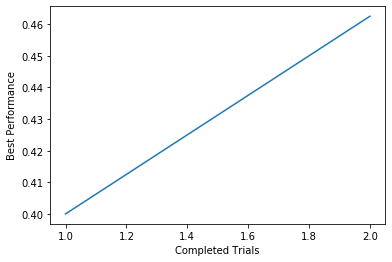

In [9]:
summary = classifier.fit_summary(output_directory=model_folder, verbosity=4)

Here's an overview of the steps automatically performed by AutoGluon during the execution of `fit()`: 

**1)** Preprocess raw data and split into training/validation sets.

Preprocessing includes [resizing/cropping](https://mxnet.apache.org/versions/1.5.0/tutorials/gluon/transforms.html) images to ensure they are the right size for our models, as well as [normalizing](https://mxnet.apache.org/versions/1.5.0/tutorials/gluon/transforms.html) the values at each pixel based on their statistics across the dataset.


**2)** Optionally apply [data augmentation](http://d2l.ai/chapter_computer-vision/image-augmentation.html) to increase the size of the dataset available for training. 

Augmenting the dataset with synthetically-generated examples may boost the resulting accuracy, but can also require longer training times. The simple-yet-effective [Mixup augmentation](https://arxiv.org/abs/1812.01187) strategy can be used by specifying the fit argument: `tricks = {'mixup': True}`. In practice, augmentation will often be applied during training when one mini-batch of training examples is loaded at a time.  

<img src="files/images/mixup.png" width="500" height="400">


**3)** Load [pretrained convolutional neural network](https://gluon-cv.mxnet.io/model_zoo/classification.html) from
[GluonCV](https://gluon-cv.mxnet.io/) that has previously been trained on a large image dataset.

By starting from an already trained network and [fine-tuning](http://d2l.ai/chapter_computer-vision/fine-tuning.html) this network's parameters on our dataset, our resulting model can transfer its previously-learned knowledge of useful image-features to our dataset. Transfer learning enables the model to achieve good accuracy with less data than we would otherwise need to provide if training the network from scratch. Nonetheless you can still disable transfer-learning and train from scratch if you prefer, by specifying the [fit argument](https://autogluon.mxnet.io/api/autogluon.task.html#autogluon.task.ImageClassification.fit): `use_pretrained=False`. 

<img src="files/images/modelzoo.png" width="350" height="300">

**4)** Setup a suitable network architecture for this particular classification task.

This is generally accomplished by modifying the output layer of the pretrained network. For example: if your training dataset has 10 classes but the pretrained network was previously learned with a different number of classes, then
AutoGluon will replace the previous output layer with a new one (with randomly initialized parameters) that outputs a 10-dimensional vector (of predicted class probailities).

<img src="files/images/finetune.svg" width="400" height="400">


**5)** Repeatedly train neural networks under different hyperparameter configurations to find the best hyperparameters. 

Each training-run of a network may leverage multiple GPUs, and two training-runs of networks with different hyperparameters may be run in parallel on different (sets of) GPUs as well. For example, if your machine has 4 GPUs, and you specify `ngpus_pertrial=2`, then AutoGluon will at any given time be running two training jobs in parallel, each using 2 GPUs. Hyperparameter-tuning will be further described in the next tutorial.

<img src="files/images/autogluon_system.png" width="400" height="400">


**6)** Retrain our final model on full training+validation dataset. 

Here we train our final network on the entire dataset (merging training+validation) using the same hyperparameter values (including number of training epochs) as the network that previously performed best on the validation data. This is the model that will be used for inference on new data, and its accuracy benefits from being retrained on a larger dataset.  Note there is no validation data available to gauge the performance of this network, which is why it is trained under the same hyperparameter-configuration previously observed to work best.


**7)** Optionally construct more-accurate model ensemble of multiple networks, by setting the [fit argument](https://autogluon.mxnet.io/api/autogluon.task.html#autogluon.task.ImageClassification.fit): `ensemble` to the desired number of networks in your ensemble (more networks usually lead to improved accuracy but greater inference-latency/memory-footprint).

Running the code in this tutorial, we see that image-classification models tend to be much larger/slower than our models for tabular data. Thus, ensembling these models via multi-layer stacking with bagging would be quite cumbersome. We instead adopt a popular strategy known as [Deep Ensembles (Lakshminarayanan, 2017)](https://papers.nips.cc/paper/7219-simple-and-scalable-predictive-uncertainty-estimation-using-deep-ensembles.pdf): simply retrain $K$ different networks (on the same training data) all using the same hyperparameter values that previously exhibited the best validation performance. These networks only differ in their random initializations and randomness in the training process (e.g. the mini-batches of data used for stochastic gradient updates of their parameters). Since neural network optimization is highly non-convex, this simple technique suffices to create a diverse ensemble (typically values of $K$ between 3-10 are used).

<img src="files/images/deepensemble.png" width="300" height="300">

Beyond these steps, AutoGluon's `fit()` offers additional `tricks` that can be used to further boost image-classification accuracy ([He et al, 2019](https://arxiv.org/abs/1812.01187)), which are listed in the [fit documentation](https://autogluon.mxnet.io/api/autogluon.task.html#autogluon.task.ImageClassification.fit).

## References

[**AutoGluon Documentation** (autogluon.mxnet.io)](https://autogluon.mxnet.io/api/autogluon.task.html)

Sun et al. [**Accurate image classification in 3 lines of code with AutoGluon**](https://medium.com/@zhanghang0704/image-classification-on-kaggle-using-autogluon-fc896e74d7e8). *Medium*, 2020.

Zhang et al. [**Dive into Deep Learning**](http://d2l.ai/). *http:d2l.ai*, 2020.

Guo et al. [**GluonCV and GluonNLP: Deep Learning in Computer Vision and Natural Language Processing**](http://jmlr.org/papers/v21/19-429.html). *Journal of Machine Learning Research*, 2020.

Lakshminarayanan et al. [**Simple and Scalable Predictive Uncertainty
Estimation using Deep Ensembles**](https://papers.nips.cc/paper/7219-simple-and-scalable-predictive-uncertainty-estimation-using-deep-ensembles.pdf). In: *NIPS*, 2017.

He et al. [**Bag of Tricks for Image Classification with Convolutional Neural Networks**](https://arxiv.org/abs/1812.01187). In: *CVPR*, 2019.